##### Common Alpha Factors

In [1]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from pathlib import Path
import numpy as np
import pandas as pd
import gc

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

##### Load Data

In [4]:
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    data = store['data/top500_dataset']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1336327 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZION', Timestamp('2023-08-10 00:00:00'))
Data columns (total 19 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   open         1336327 non-null  float64
 1   high         1336327 non-null  float64
 2   low          1336327 non-null  float64
 3   close        1336327 non-null  float64
 4   volume       1336327 non-null  float64
 5   market cap   1336327 non-null  float64
 6   sector       1336327 non-null  float64
 7   ret_01d      1335827 non-null  float64
 8   ret_02d      1335327 non-null  float64
 9   ret_03d      1334827 non-null  float64
 10  ret_04d      1334327 non-null  float64
 11  ret_05d      1333827 non-null  float64
 12  ret_10d      1331327 non-null  float64
 13  ret_21d      1325827 non-null  float64
 14  ret_42d      1315327 non-null  float64
 15  ret_63d      1304827 non-null  float64
 16  ret_126d     127

##### TA-Lib: Function Groups

List number of available functions by group

In [7]:
function_groups = ['Overlap Studies',
                   'Momentum Indicators',
                   'Volume Indicators',
                   'Volatility Indicators',
                   'Price Transform',
                   'Cycle Indicators',
                   'Pattern Recognition',
                   'Statistic Functions',
                   'Math Transform',
                   'Math Operators']

talib_grps = talib.get_function_groups()

In [8]:
import pandas as pd
import talib.abstract as ta
import logging
import talib
import numpy as np

# The 5 days can be seen as a very short-term trend.
# The 21 days can be used to determine the medium-term trend.
# The 63 days can be viewed as a longer-term trend.

def compute_talib_indicators(df, function_groups, timeperiods=[5, 21, 63]):
    """
    Compute indicators for the specified function groups using TA-Lib's Abstract API.
    
    Parameters:
    - df: DataFrame with columns 'open', 'high', 'low', 'close', and optionally 'volume'.
    - function_groups: List of function groups to compute.
    """
    
    # Organize data in the format needed for TA-Lib Abstract API
    inputs = {
        'open': df['open'].astype(float).values,
        'high': df['high'].astype(float).values,
        'low': df['low'].astype(float).values,
        'close': df['close'].astype(float).values,
        'volume': df['volume'].astype(float).values if 'volume' in df.columns else np.random.random(len(df))
    }

    talib_functions = {k: v for k, v in talib.get_function_groups().items() if k in function_groups}

    success_count = 0
    failure_count = 0
    
    for group, indicators in talib_functions.items():
        for indicator_name in indicators:
            for timeperiod in timeperiods:
                try:
                    indicator_func = ta.Function(indicator_name)

                    parameters = {}
                    if 'timeperiod' in indicator_func.parameters:
                        parameters['timeperiod'] = timeperiod

                    if indicator_name == 'MAVP':
                        inputs['periods'] = np.full(len(df), timeperiod, dtype=np.float64)

                    outputs = indicator_func(inputs, **parameters)

                    # For multi-output functions, like 'BBANDS'
                    if isinstance(outputs, (list, tuple)):
                        for i, out_name in enumerate(indicator_func.output_names):
                            col_name = f"{out_name}_{timeperiod}".upper()
                            df[col_name] = outputs[i]
                    else:
                        col_name = f"{indicator_name}_{timeperiod}".upper()
                        df[col_name] = outputs

                    success_count += 1
                except Exception as e:
                    logging.warning(f"{indicator_name}_{timeperiod} failed due to: {str(e)}")
                    failure_count += 1

    print(f"{success_count} indicators added successfully.")
    print(f"{failure_count} indicators failed.")

    return df

function_groups = [
    'Overlap Studies',
    'Momentum Indicators',
    'Volume Indicators',
    'Volatility Indicators',
    'Price Transform',
    'Cycle Indicators',
    'Pattern Recognition',
    'Statistic Functions',
    'Math Transform',
    'Math Operators'
]

# Assuming you've read your dataframe into a variable named 'data'
data_ta = compute_talib_indicators(data.copy(), function_groups)

474 indicators added successfully.
0 indicators failed.


In [9]:
data_ta.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1336327 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZION', Timestamp('2023-08-10 00:00:00'))
Columns: 514 entries, open to OBV_63
dtypes: float64(316), int32(198)
memory usage: 4.1+ GB


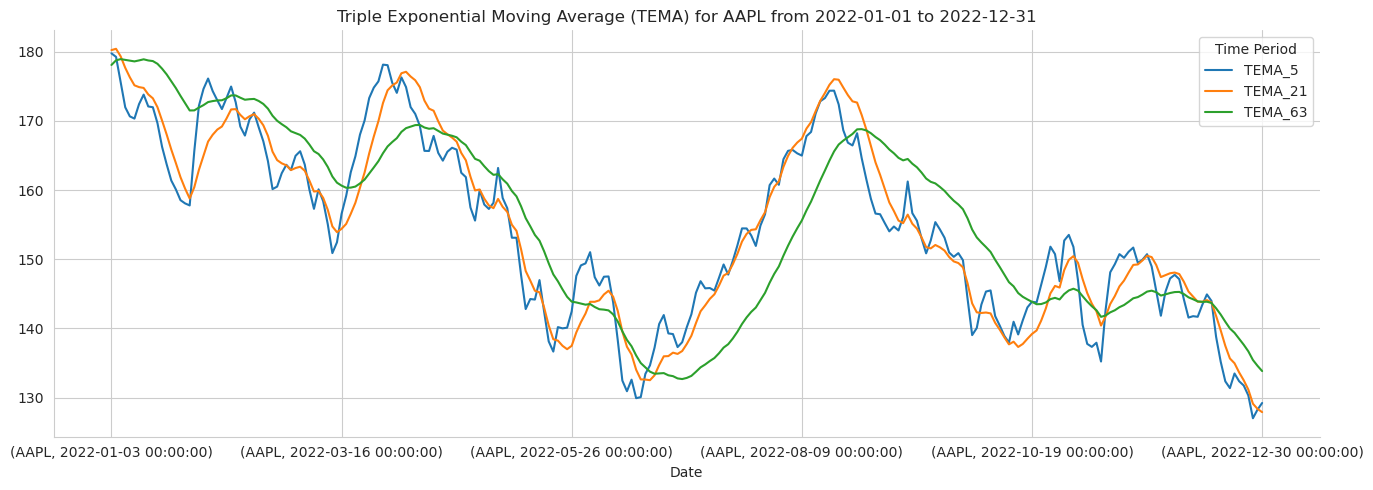

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_tema_for_ticker(data, ticker, start_date, end_date, time_periods=[5, 21, 63]):
    """
    Plot the Triple Exponential Moving Average (TEMA) for a given ticker over a specified time range.
    
    Parameters:
        data (pd.DataFrame): The dataset with multi-index ['ticker', 'date'] and TEMA columns.
        ticker (str): The ticker to plot.
        start_date (str): The start date of the range.
        end_date (str): The end date of the range.
        time_periods (list): List of time periods for which TEMA has been computed. Default is [5, 21, 63].
    """
    
    # Ensure the data's MultiIndex is sorted
    data_sorted = data.sort_index()
    
    # Filter the data for the desired ticker and date range
    filtered_data = data_sorted.loc[(ticker, slice(start_date, end_date)), :]
    
    # Get the relevant TEMA columns
    tema_columns = [f'TEMA_{t}' for t in time_periods]
    df_tema = filtered_data[tema_columns]
    
    # Plot the data
    ax = df_tema.plot(figsize=(14, 5), rot=0, title=f"Triple Exponential Moving Average (TEMA) for {ticker} from {start_date} to {end_date}")
    sns.despine()
    ax.set_xlabel('Date')
    ax.legend(title="Time Period")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_tema_for_ticker(data_ta, 'AAPL', '2022-01-01', '2022-12-31')


In [11]:
data_ta.to_hdf(DATA_STORE, 'data/top500_dataset_with_TA')

In [12]:
del data_ta

## Rolling Factor Betas

In [13]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=2005)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']

In [14]:
factors = factor_data.columns[:-1]
factors

Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

In [15]:
factors

Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

In [16]:
t = 1
ret = f'ret_{t:02}d'

windows = [21, 63, 252]
for window in windows:
    print(window)
    betas = []
    for ticker, df in data.groupby('ticker', group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret], 
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True).swaplevel()
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}')
    data = data.join(betas)

21
63
252


##### Size proxy

In [17]:
by_ticker = data.groupby('ticker', group_keys=False)
data['size_factor'] = by_ticker.close.apply(lambda x: x.fillna(method='bfill').div(x.iloc[0]))
data['size_proxy'] = data['market cap'].mul(data.size_factor).div(1e6)

In [18]:
data.to_hdf(DATA_STORE, 'data/top500_dataset_with_rolling_beta_size_proxy')

In [19]:
del data

##### Joining the dataframe

In [5]:
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

with pd.HDFStore(DATA_STORE) as store:
    data_ta = store['data/top500_dataset_with_TA']
    data = store['data/top500_dataset_with_rolling_beta_size_proxy']


def optimize_dataframe(df):
    # Convert float64 to float32
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
        
    return df

data = optimize_dataframe(data.copy())
data_ta = optimize_dataframe(data_ta.copy())

import pandas as pd

common_cols = set(data_ta.columns).intersection(data.columns)
# print(common_cols)
# Drop common columns from 'data' before merging. This helps avoid duplicated columns in the merge.
data = data.drop(columns=common_cols)

# Merge on multi-index
merged_data = data_ta.merge(data, left_index=True, right_index=True, how='inner')

merged_data.dropna(how='all').info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10914535 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZTS', Timestamp('2023-08-10 00:00:00'))
Columns: 534 entries, open to size_proxy
dtypes: float32(304), float64(32), int32(198)
memory usage: 23.1+ GB


In [9]:
# First, use forward fill
merged_data.ffill(inplace=True)

# Then, use backward fill for any remaining NaNs
merged_data.bfill(inplace=True)


In [10]:
# Drop rows where any value is NaN
cleaned_data = merged_data.dropna(how='any')

# Or, drop columns where any value is NaN
cleaned_data = merged_data.dropna(how='any', axis=1)


In [11]:
cleaned_data

open        high         low       close  \
ticker date                                                         
AA     2013-01-03   18.904100   19.306499   18.883200   19.137600   
       2013-01-04   19.222000   19.579800   19.200300   19.537100   
       2013-01-07   19.537100   19.600599   19.200300   19.200300   
       2013-01-08   19.327400   19.389099   19.158400   19.200300   
       2013-01-09   19.685101   19.685101   19.115700   19.158400   
...                       ...         ...         ...         ...   
ZTS    2023-08-04  180.139999  182.460007  178.339996  178.630005   
       2023-08-07  180.190002  181.880005  180.029999  180.690002   
       2023-08-08  182.149994  190.539993  177.250000  189.300003   
       2023-08-09  189.940002  190.949997  186.964996  189.350006   
       2023-08-10  190.000000  191.824997  187.729996  189.100006   

                         volume    market cap  sector   ret_01d   ret_02d  \
ticker date                                                                 
AA     2013-01-03  1.057118e+07  5.703249e+09     4.0  0.020875  0.003276   
       2013-01-04  8.690739e+06  5.703249e+09     4.0  0.020875  0.003276   
       2013-01-07  1.031992e+07  5.703249e+09     4.0 -0.017239  0.003276   
       2013-01-08  1.609879e+07  5.703249e+09     4.0  0.000000 -0.017239   
       2013-01-09  1.979932e+07  5.703249e+09     4.0 -0.002182 -0.002182   
...                         ...           ...     ...       ...       ...   
ZTS    2023-08-04  1.827463e+06  8.818486e+10     2.0 -0.012439 -0.018516   
       2023-08-07  1.941699e+06  8.818486e+10     2.0  0.011532 -0.001050   
       2023-08-08  4.117986e+06  8.818486e+10     2.0  0.047651  0.059732   
       2023-08-09  2.270030e+06  8.818486e+10     2.0  0.000264  0.047927   
       2023-08-10  2.348639e+06  8.818486e+10     2.0 -0.001320 -0.001057   

                    ret_03d   ret_04d   ret_05d   ret_10d   ret_21d   ret_42d  \
ticker date                                                                     
AA     2013-01-03  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-04  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-07  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-08  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-09 -0.019384  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
...                     ...       ...       ...       ...       ...       ...   
ZTS    2023-08-04 -0.037087 -0.050295 -0.059347 -0.026593  0.060307  0.043887   
       2023-08-07 -0.007198 -0.025982 -0.039343 -0.026350  0.081070  0.062008   
       2023-08-08  0.046550  0.040110  0.020430 -0.004470  0.112090  0.157232   
       2023-08-09  0.060012  0.046827  0.040385 -0.013802  0.112907  0.152465   
       2023-08-10  0.046544  0.058613  0.045444  0.002173  0.100314  0.159482   

                    ret_63d  ret_126d  ret_252d  ret_fwd_01d  HT_DCPERIOD_5  \
ticker date                                                                   
AA     2013-01-03 -0.088433 -0.133089  0.181219     0.020875      15.646696   
       2013-01-04 -0.088433 -0.133089  0.181219    -0.017239      15.646696   
       2013-01-07 -0.088433 -0.133089  0.181219     0.000000      15.646696   
       2013-01-08 -0.088433 -0.133089  0.181219    -0.002182      15.646696   
       2013-01-09 -0.088433 -0.133089  0.181219    -0.012136      15.646696   
...                     ...       ...       ...          ...            ...   
ZTS    2023-08-04  0.000897  0.044620 -0.006386     0.011532      19.282707   
       2023-08-07 -0.029748  0.076818  0.038806     0.047651      19.354801   
       2023-08-08  0.023963  0.147760  0.086433     0.000264      19.373043   
       2023-08-09  0.027011  0.143625  0.090468    -0.001320      19.349129   
       2023-08-10  0.021389  0.166780  0.117672     0.009149      19.317390   

                   HT_DCPERIOD_21  HT_DCPER

In [ ]:
with pd.HDFStore('data.h5') as store:
    store.put('factors/common', data)